In [1]:
import sys,os
import pandas as pd
import numpy as np
import warnings

import tensorflow as tf
from sklearn.utils import shuffle
from joblib import load, dump
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.metrics import structural_similarity as ssim

from aggmap import AggMap
from aggmap.utils.matrixopt import smartpadding
import aggmap

sns.set(style = 'white', font_scale=1.5)

warnings.filterwarnings("ignore")

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#34ebe8",'gray', 'k'])



## usefull link: https://towardsdatascience.com/how-to-program-umap-from-scratch-e6eff67f55fe

/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/molmap/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/s

## $\sum_{e\in E} w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right) + (1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)$

### This might look complicated, but if we go back to thinking in terms of a graph we can view minimizing the cross entropy as a kind of force directed graph layout algorithm.

### The first term, $w_h(e) \log\left(\frac{w_h(e)}{w_l(e)}\right)$, provides an attractive force between the points e spans whenever there is a large weight associated to the high dimensional case. This is because this term will be minimized when $w_l(e)$ is as large as possible, which will occur when the distance between the points is as small as possible.

### In contrast the second term, $(1 - w_h(e)) \log\left(\frac{1 - w_h(e)}{1 - w_l(e)}\right)$, provides a repulsive force between the ends of e whenever $w_h(e)$ is small. This is because the term will be minimized by making w_l(e) as small as possible.

### On balance this process of pull and push, mediated by the weights on edges of the topological representation of the high dimensional data, will let the low dimensional representation settle into a state that relatively accurately represents the overall topology of the source data.

In [2]:
from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm

def get_graph_v(embd):
    '''
    Get the graph in low dimension
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))        
    return graph_v

def get_graph_u(embd):
    '''
    Get the graph in high dimension
    '''
    return embd.graph_.toarray()

def cross_entropy_via_scipy(gu, gv):
        ''' SEE: https://en.wikipedia.org/wiki/Cross_entropy'''
        return  entropy(gu) + entropy(gu, gv)
    
def get_loss_pcc_from_embd(embd):
    gv = get_graph_v(embd)
    np.fill_diagonal(gv,0)
    gv = squareform(gv)
    gu = get_graph_u(embd)
    gu = squareform(gu)
    l1 = pd.Series(gu).to_frame(name = 'y_true')
    l2 = pd.Series(gv).to_frame(name = 'y_pred')
    pcc = l1.join(l2).corr().iloc[0].iloc[1]
    loss = cross_entropy_via_scipy(gu, gv)
    return loss, pcc

In [3]:
img_save_dir = './frames/MNIST'
if not os.path.exists(img_save_dir):
    os.makedirs(img_save_dir)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() #
label_idx = pd.Series(y_train).to_frame(name='label').groupby('label').apply(lambda x:x.index.tolist())
label_idx

label
0    [1, 21, 34, 37, 51, 56, 63, 68, 69, 75, 81, 88...
1    [3, 6, 8, 14, 23, 24, 40, 59, 67, 70, 72, 77, ...
2    [5, 16, 25, 28, 76, 82, 109, 117, 120, 122, 14...
3    [7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 10...
4    [2, 9, 20, 26, 53, 58, 60, 61, 64, 89, 92, 115...
5    [0, 11, 35, 47, 65, 100, 132, 138, 145, 173, 1...
6    [13, 18, 32, 36, 39, 62, 66, 73, 83, 90, 93, 1...
7    [15, 29, 38, 42, 52, 71, 79, 84, 91, 96, 101, ...
8    [17, 31, 41, 46, 55, 85, 94, 97, 125, 137, 144...
9    [4, 19, 22, 33, 43, 45, 48, 54, 57, 80, 87, 11...
dtype: object

In [5]:
_, w, h = x_train.shape
orignal_cols = ['p-%s' % str((i+1)).zfill(len(str(w*h))) for i in range(w*h)]
x_train_df = pd.DataFrame(x_train.reshape(x_train.shape[0], w*h), columns = orignal_cols)
x_test_df = pd.DataFrame(x_test.reshape(x_test.shape[0], w*h), columns = orignal_cols)


### random permutation

In [6]:
shuffled_cols = shuffle(orignal_cols, random_state=111)
x_train_df_shuffled = x_train_df[shuffled_cols]
x_test_df_shuffled = x_test_df[shuffled_cols]

In [7]:
mp = AggMap(x_train_df_shuffled, metric='correlation')

2021-10-26 19:26:20,158 - INFO - [bidd-aggmap] - Calculating distance ...
2021-10-26 19:26:20,194 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 784/784 [00:01<00:00, 434.20it/s]


In [8]:
idx_to_plot = label_idx.iloc[[1,3,5,7,9]].apply(lambda x:x[0])
idx_to_plot.index = idx_to_plot.index.astype(str)
idx_to_plot.to_dict()

{'1': 3, '3': 7, '5': 0, '7': 15, '9': 4}

In [9]:
total_epochs = 500
begin_epochs = 1 # Need to comment out the error throwing of epochs less than 10 in UMAP
step = 1

learning_rate = 5e-1

mp = mp.fit(n_epochs = total_epochs, learning_rate = learning_rate, cluster_channels=1, var_thr=0, verbose=0)    

2021-10-26 19:27:25,327 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2021-10-26 19:27:30,507 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2021-10-26 19:27:31,177 - INFO - [bidd-aggmap] - Finished


In [10]:
embd = mp.embedded

# 获取高维图

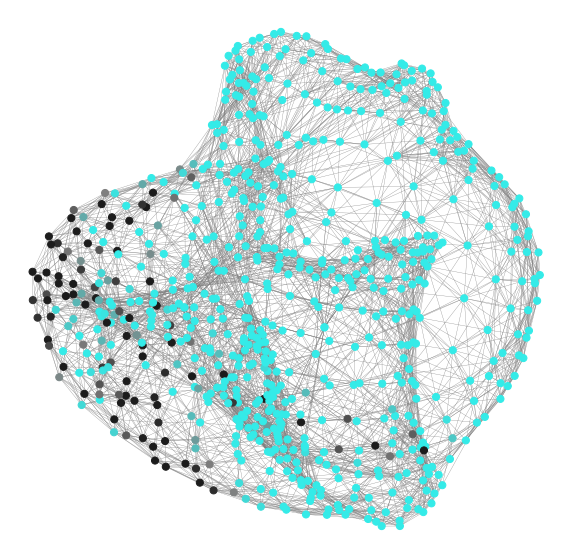

In [88]:
import networkx as nx

fig, ax = plt.subplots(figsize = (10, 10))
A = embd.graph_.toarray()

G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 900)

dfs = mp.df_embedding[['x','y']]
dfs = dfs.join(x_train_df_shuffled.iloc[4].to_frame(name = 'c'))

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.3, node_color= dfs.c, cmap=cmap)


<AxesSubplot:>

(-0.9600495100021362,
 1.0933356285095215,
 -1.0038248032331467,
 1.0685316652059555)

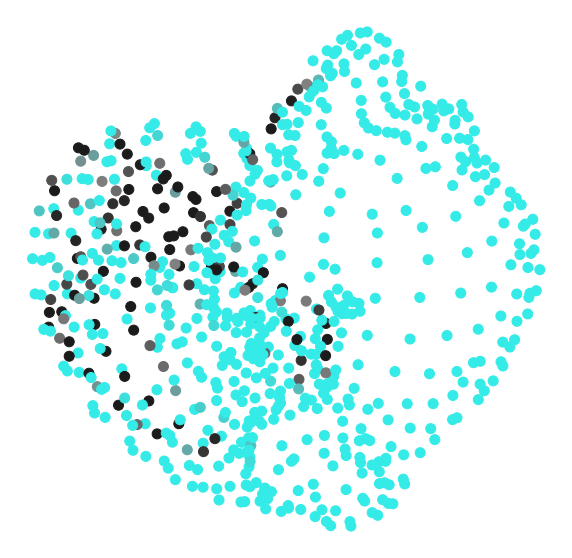

In [47]:

A = embd.graph_.toarray()

G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 1000)


fig, ax = plt.subplots(figsize = (10, 10))


dfxy = pd.DataFrame(layout).T
dfxy.columns = ['x', 'y']
dfxy.index = mp.flist
dfs = dfxy.join(x_train_df_shuffled.iloc[0].to_frame(name = 'c'))

ax.scatter(dfs.x, dfs.y, c = dfs.c, s=100, cmap = cmap)
plt.axis('off')



(-0.9600495100021362,
 1.0933356285095215,
 -1.0038248032331467,
 1.0685316652059555)

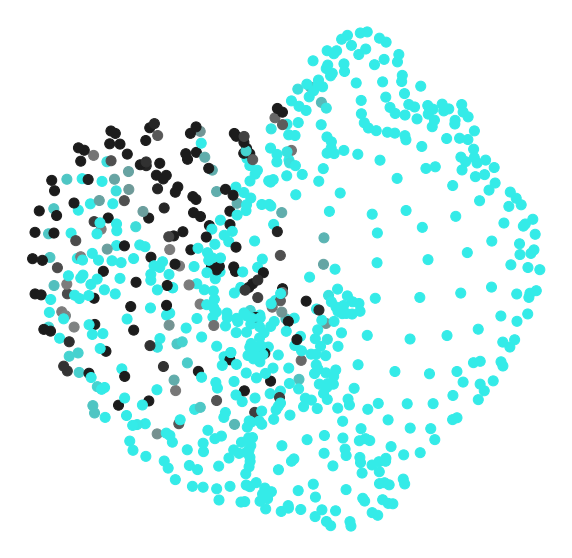

In [48]:
fig, ax = plt.subplots(figsize = (10, 10))


dfxy = pd.DataFrame(layout).T
dfxy.columns = ['x', 'y']
dfxy.index = mp.flist
dfs = dfxy.join(x_train_df_shuffled.iloc[7].to_frame(name = 'c'))

ax.scatter(dfs.x, dfs.y, c = dfs.c, s=100, cmap = cmap)
plt.axis('off')


## 获取初始化

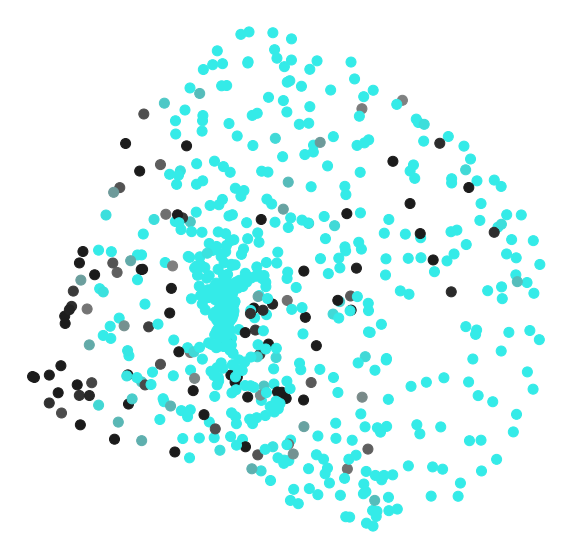

In [79]:

from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import euclidean_distances

model = SpectralEmbedding(n_components = 2, n_neighbors = 100, affinity = 'precomputed') #]
dfd = pd.DataFrame(squareform(mp.info_distance), index=mp.alist, columns=mp.alist)
dist = dfd.loc[mp.flist][mp.flist].values

#dist = squareform(mp.info_distance)
affinity_matrix  = np.exp(-(dist ** 2))

se = model.fit_transform(affinity_matrix) #
se /= se.max()
dfi = pd.DataFrame(se, index=mp.flist)
dfi.columns = ['x', 'y']
dfi = dfi.join(x_train_df_shuffled.iloc[4].to_frame(name = 'c'))
plt.figure(figsize=(10,10))
plt.scatter(dfi.x, dfi.y, c = dfi.c, cmap = cmap, s = 100) # c = y_train.astype(int),
plt.axis('off')

## 获取低维图

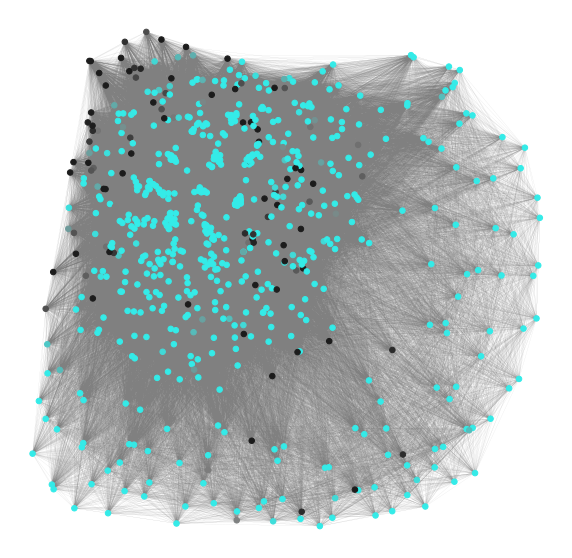

In [90]:

def prob_low_dim(Y):
    """
    Compute matrix of probabilities v_ij in low-dimensional space
    """
    #a=1.577
    #b=0.895
    
    a=1
    b=1
    
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances

v_ij = prob_low_dim(se)

A = v_ij*(v_ij > 0.6)

G = nx.from_numpy_matrix(A)
layout = nx.spring_layout(G, iterations = 900)

fig, ax = plt.subplots(figsize = (10, 10))

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.01, node_color= dfs.c, cmap=cmap)


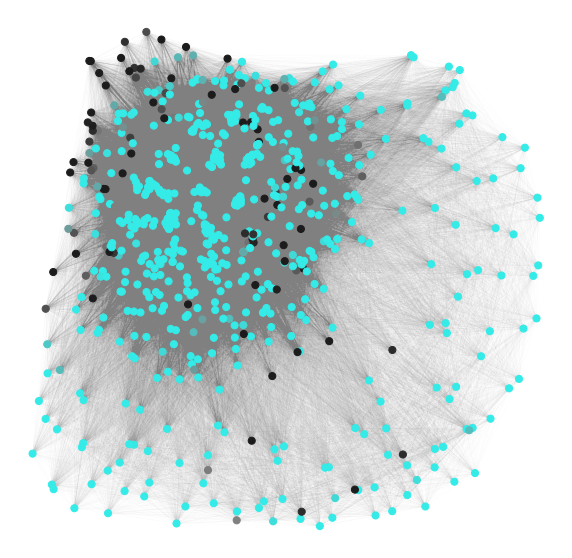

In [91]:
fig, ax = plt.subplots(figsize = (10, 10))

nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.01, node_color= dfs.c, cmap=cmap)


## 获取最终图

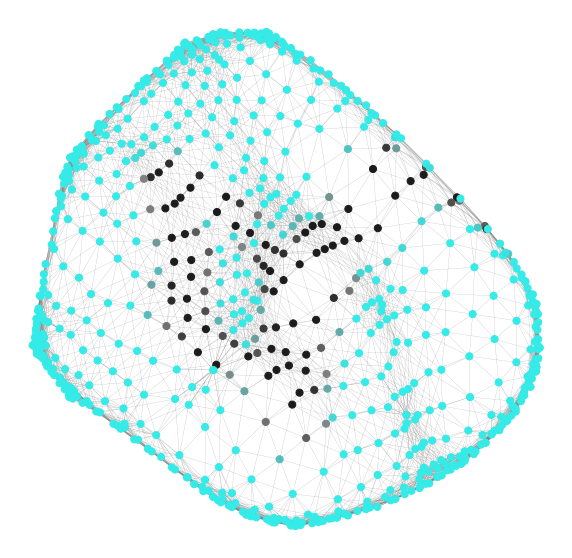

In [85]:


fig, ax = plt.subplots(figsize = (10, 10))
gv = get_graph_v(embd)
#np.fill_diagonal(gv,0)

A = gv*(gv > 0.5)

G = nx.from_numpy_matrix(np.matrix(A))
layout = nx.spring_layout(G, iterations = 900)
nx.draw(G, layout, ax = ax, node_size = 50, edge_color = 'gray', width = 0.15, node_color= dfs.c, cmap=cmap)
#nx.draw_networkx_edge_labels(G, pos=layout)
